This file is to price snowball by monte carlo simulation method and binomial tree method with forward shooting grid function.
The basic assumption about the snowball:
$$Notiontal amount(N):100\_000\_000,\ \ stock\ volatility(\sigma): 0.16,$$
$$risk\ free intetrest(r)=3\%,\ \ securities\ borrowing(q):9.5\%$$
$$knock-out\ coupon\ rate(kc)=16\%, \ \ coupon\ rate(c)=16\%$$
$$invest\ horizon/time(T):24(months),\ \ locked\ time(Tl)=3(months) $$
$$stepdown(s)=0.5\%,\ \ stepdown\ begin\ time(Ts)=4 $$
$$original\ knock-out\ barrier:100\%,\ \ knock-in\ barrier=75\%$$

For computing simplicity, I assume all intervals of knock-out day are the 1 month with 30/360 daily counting convention and
The interval can be divide into one day if necessary.


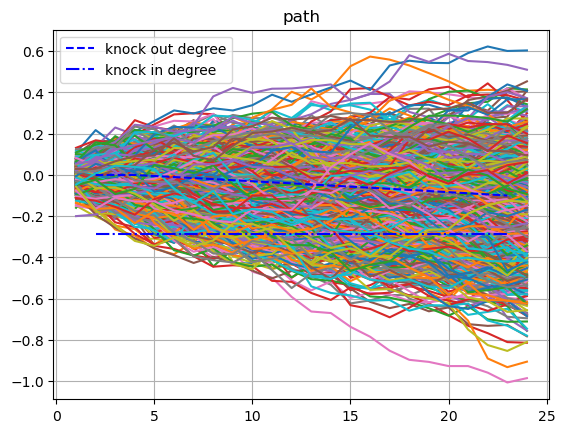

In [27]:
#monte carlo method 
import numpy as np
import matplotlib.pyplot as plt
#we denote the price level with log(S) to avoid time-costing logarithm comuptation\
#in monte carlo process
r=0.03;q=0.095;sigma=0.16;dt=1/12;T=2;N=100_000_000
knock_in=0.75;n=1000000
#We use argmax to postion the index of knock/in event, if we only use 22 data, we cannot
#distinguish whether the first observation month encounter knock/in or knock/in no event happens in
#the full trail. First two observation months dont exist,so we set them to 100, 
#as impossible to knock out, so if knock/in event happens in the third observation month, argmax
#will return index 2; return 0 if no knock/in event happens.
knock_out_degree_array=np.array([*([100]*2),*([0]*22)],dtype=float)
knock_out_degree_array[-20:]=np.log(np.linspace(1,0.905,20))
path=np.random.randn(n,24)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
path=path.cumsum(axis=1)

plt.plot(range(1,25),path[:min(1000,path.shape[0]),:].T)
plt.plot(range(2,24),knock_out_degree_array[-22:],'b--',label='knock out degree')
plt.plot(range(2,24),np.log(knock_in)*np.ones(22),'b-.',label='knock in degree')
plt.legend()
plt.grid()
plt.title('path')
plt.show()

In [43]:
arg_knockout=np.argmax(path[:,]>knock_out_degree_array,axis=1)
arg_knockin=np.argmax(path[:,]<np.log(knock_in),axis=1)
arg_knockout_indicatior=arg_knockout>=2
arg_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin>=2)
arg_no_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin<2)
#knockout and no knockin
value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
#no knockout and no knockin
value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*2*0.16*np.exp(-r*2)
#knock in and no knockout, similar to a put option 
array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*2)
print("the trails that knockout happens:\t\t\t",arg_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_out.mean())
print("the trails that knockin happens and no knockout happen:\t",arg_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", array_in_noout.mean())
print("the trails that no knockout and knockout happens:\t",arg_no_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_noin_noout.mean())
print("pricing of snowball by monte carlo simulation:\t\t",(value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n*N)



the trails that knockout happens:			 0.753395 
averate payoff:	 0.06353798133082161
the trails that knockin happens and no knockout happen:	 0.212512 
averate payoff:	 -0.32272130485716927
the trails that no knockout and knockout happens:	 0.034093 
averate payoff:	 0.30136465074695973
pricing of snowball by monte carlo simulation:		 -644461.3965733108


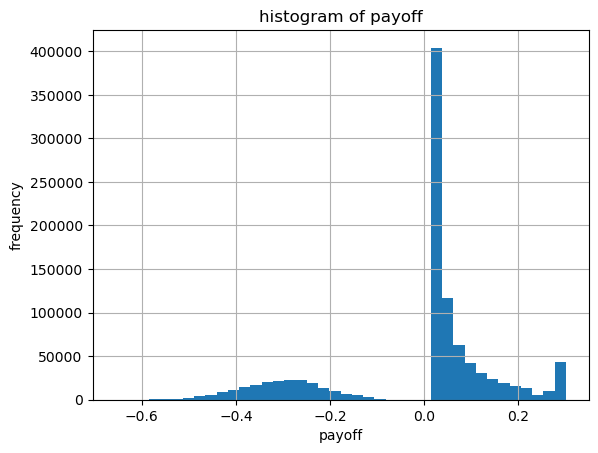

In [38]:
result=np.concatenate((value_out,value_noin_noout,value_in_noout),axis=0)
plt.hist(result,bins=40)
plt.xlabel('payoff')
plt.ylabel('frequency')
plt.grid()
plt.title('histogram of payoff')
plt.show()

In [45]:
r=0.03;q=0.095;sigma=0.16;dt=1/12;T=2;S0=1
knock_in=0.75;n=1000000
#We use argmax to postion the index of knock/in event, if we only use 22 data, we cannot
#distinguish whether the first observation month encounter knock/in or knock/in no event happens in
#the full trail. First two observation months dont exist,so we set them to 100, 
#as impossible to knock out, so if knock/in event happens in the third observation month, argmax
#will return index 2; return 0 if no knock/in event happens.
knock_out_degree_array=np.array([*([100]*2),*([0]*22)],dtype=float)
knock_out_degree_array[-20:]=np.log(np.linspace(1,0.905,20))
path=np.random.randn(n,24)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
path=path.cumsum(axis=1)

arg_knockout=np.argmax(path[:,]>knock_out_degree_array,axis=1)
arg_knockin=np.argmax(path[:,]<np.log(knock_in),axis=1)
arg_knockout_indicatior=arg_knockout>=2
arg_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin>=2)
arg_no_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin<2)
#knockout and no knockin
value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
#no knockout and no knockin
value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*2*0.16*np.exp(-r*2)
#knock in and no knockout, similar to a put option 
array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*2)
(value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n

-639723.2090318918

In [ ]:
def snowball_pricing(r=0.03,t=0,sigma=0.16,S=1):
    q=0.095;dt=1/12;T=2;knock_in=0.75;n=1000000
    knock_out_degree_array=np.array([*([100]*2),*([0]*22)],dtype=float)
    knock_out_degree_array[-20:]=np.log(np.linspace(1,0.905,20))
    path=np.random.randn(n,24)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
    path=path.cumsum(axis=1)
    arg_knockout=np.argmax(path[:,]>knock_out_degree_array,axis=1)
    arg_knockin=np.argmax(path[:,]<np.log(knock_in),axis=1)
    arg_knockout_indicatior=arg_knockout>=2
    arg_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin>=2)
    arg_no_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin<2)
    #knockout and no knockin
    value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
    #no knockout and no knockin
    value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*2*0.16*np.exp(-r*2)
    #knock in and no knockout, similar to a put option 
    array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
    value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*2)
    return (value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n

In [1]:
#pricing by binomial tree with forward shooting grid method
import numpy as np

r=0.03;q=0.095;sigma=0.16;dt=1/12;T=2;N=100_000_000
knock_in=0.75;n=100000;c=0.16
u=np.exp(sigma*np.sqrt(dt))
d=1/u
p=(np.exp((r-q)*dt)-d)/(u-d)
panel=np.full((25,25*2),np.nan)
#panel=np.zeros((25,25*2))
#in term i, there are i+1 nodes for stock(j times u and i-j times d),
#and two nodes for whether knock/in(k=1 denotes knockin event happened),
#we present the situaition with k*(i+1)+j, get the terminal payoff and backward calculate
knock_out_degree_array=np.array([*[1]*2,*np.linspace(1,0.905,20)],dtype=float)
for i in reversed(range(25)):
    for j in range(i+1):
        S=u**(j)*d**(i-j)
        if i==2:
            if S*d<knock_in and S>knock_in:
                panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,1*(i+2)+j])
            elif S*d<knock_in and S<knock_in:
                panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,1*(i+2)+j+1]+(1-p)*panel[i+1,1*(i+2)+j])
            else: panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,j])
        elif i<2:
            panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,j])
        else:
            for k in range(2):
                if i==24:
                    panel[i,k*(i+1)+j]=(S>knock_out_degree_array[i-3])*i*dt*c+\
                        (S<knock_out_degree_array[i-3])*(k==0)*i*dt*c+\
                            (S<knock_out_degree_array[i-3])*(k==1)*min(S-1,0)
                elif i>2:
                    if S>=knock_out_degree_array[i-3]:
                        panel[i,k*(i+1)+j]=dt*i*c
                    else:
                        if k==1:
                            panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,k*(i+2)+j])
                        if k==0:
                            if S*d<knock_in:
                                panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,1*(i+2)+j])
                            else:
                                panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,k*(i+2)+j])
print(panel[0,0]*N)

577754.9731932806
